In [14]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
import cv2 as cv
from IPython.display import Image
from IPython.display import Video
import os

tf.initialize(tf.opengl)

M = 1920
N = 1080 

boundary_thickness = 3

def Bilinear(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)
    oxf, oyf = 1.0-xf, 1.0-yf
    return tex[xi, yi]*oxf*oyf + tex[xi+1, yi]*xf*oyf + tex[xi, yi+1]*oxf*yf + tex[xi+1, yi+1]*xf*yf

def CubicHermit(x):
    x2 = x * x
    x3 = x2 * x
    return [-0.5 * x3 + x2 - 0.5 * x, 1.5 * x3 - 2.5 * x2 + 1.0, -1.5 * x3 + 2.0 * x2 + 0.5 * x, 0.5 * x3 - 0.5 * x2]

def CubicInterp(tex, x, y):
    N1, M1 = tex.shape

    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)

    wx = CubicHermit(xf)
    wy = CubicHermit(yf)

    valueY = 0.0
    for j in range(-1, 3):
        valueX = 0.0
        for i in range(-1, 3):
            valueX = valueX + tex[xi + i, yi + j] * wx[i + 1]
        valueY = valueY + valueX * wy[j + 1]
        
    return valueY

def EulerAdvection(vx, vy, dt):
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)
    x1, y1 = x - vx*dt, y - vy*dt
    return x1, y1

def RK4Advection(vx, vy, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)

    x1, y1 = x - vx*dt/2.0, y - vy*dt/2.0
    vx1, vy1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)

    x2, y2 = x - vx1*dt/2.0, y - vy1*dt/2.0
    vx2, vy2 = Bilinear(vx, x2, y2), Bilinear(vy, x2, y2)

    x3, y3 = x - vx2*dt, y - vy2*dt
    vx3, vy3 = Bilinear(vx, x3, y3), Bilinear(vy, x3, y3)

    x4, y4 = x - (vx + 2.0*vx1 + 2.0*vx2 + vx3)*dt/6.0, y - (vy + 2.0*vy1 + 2.0*vy2 + vy3)*dt/6.0
    return x4, y4

def SemiLagrange(vx, vy, pressure, density, dt):
    x1, y1 = RK4Advection(vx, vy, dt)
    #x1, y1 = EulerAdvection(vx, vy, dt)

    vxb = Bilinear(vx, x1, y1)
    vyb = Bilinear(vy, x1, y1)
    densb = Bilinear(density, x1, y1)
    thr0 = 0.97
    thr1 = 1.03
    vx = tf.clamp(CubicInterp(vx, x1, y1), tf.min(vxb*thr0, vxb*thr1), tf.max(vxb*thr0, vxb*thr1))
    vy = tf.clamp(CubicInterp(vy, x1, y1), tf.min(vyb*thr0, vyb*thr1), tf.max(vyb*thr0, vyb*thr1))
    density = tf.clamp(CubicInterp(density, x1, y1), tf.min(densb*thr0, densb*thr1), tf.max(densb*thr0, densb*thr1))
    #pressure = CubicInterp(pressure, x1, y1)
    #vx = Bilinear(vx, x1, y1)
    #vy = Bilinear(vy, x1, y1)
    #pressure = Bilinear(pressure, x1, y1)
    #densitylin = Bilinear(density, x1, y1)
    #dens1 = densitylin*0.99
    #dens2 = densitylin*1.00
    #dens3 = tf.min(dens1, dens2)
    #dens4 = tf.max(dens1, dens2)
    #density = Bilinear(density, x1, y1)

    return [vx, vy, pressure, density]

def BFECC(vx, vy, pressure, density, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)
    
    # advect backwards
    x1, y1 = x - vx*dt, y - vy*dt
    vx1, vy1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)
    density1 = Bilinear(density, x1, y1)

    # advect forwards
    x2, y2 = x + vx*dt, y + vy*dt
    vx2, vy2 = Bilinear(vx1, x2, y2), Bilinear(vy1, x2, y2)
    density2 = Bilinear(density1, x2, y2)

    # compute backwards forwards error correction
    vx = vx + (vx - vx2)*0.5
    vy = vy + (vy - vy2)*0.5
    density = density + (density - density2)*0.5

    # advect corrected backwards
    vx3, vy3 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)
    density3 = Bilinear(density, x1, y1)

    return [vx3, vy3, pressure, density3]

def Boundary(i, j):
    N1, M1 = i.shape
    return tf.select((i < boundary_thickness) | (i > N1-1-boundary_thickness) | (j < boundary_thickness) | (j > M1-1-boundary_thickness), 0.0, 1.0)

def LoadBC(f, i, j):
    return Boundary(i,j) * f[i, j]

def Jacobi(pressure, div, iterations):
    i, j = pressure.indices

    # pressure solve
    for it in range(iterations):
        pressure = (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0

    return pressure

# red-black Gauss-Seidel
def RBGS(pressure, div, iterations):
    N1, M1 = pressure.shape
    i0, j0 = tf.indices([N1, M1/2])

    overrelax = 1.0

    # pressure solve
    for it in range(iterations):
        new_pressure = tf.buffer([N1, M1], tf.float32)
        # red
        i, j = i0, 2*j0 + (i0 % 2)
        new_pressure[i,j] = pressure[i, j] * (1.0 - overrelax) + overrelax * (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div[i, j]) / 4.0

        # black
        i, j = i0, 2*j0 + ((i0+1) % 2)
        new_pressure[i,j] = pressure[i, j] * (1.0 - overrelax) + overrelax * (new_pressure[i-1, j] + new_pressure[i+1, j] + new_pressure[i, j-1] + new_pressure[i, j+1] - div[i, j]) / 4.0
        pressure = new_pressure

    return pressure

def Restrict(field):
    N1, M1 = field.shape
    N2, M2 = N1/2, M1/2
    i, j = tf.indices([N2, M2])
    i, j = 2*i, 2*j
    return 0.25*(field[i, j] + field[i+1, j] + field[i, j+1] + field[i+1, j+1])

def Prolong(field, orig):
    i, j = orig.indices
    return orig + Bilinear(field, tf.float(i)/2.0, tf.float(j)/2.0)

def Residual(pressure, div):
    i, j = pressure.indices
    return Boundary(i,j) * (div - (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - 4.0*pressure))

def VCycle(pressure, div):
    pressure = RBGS(pressure*0.0001, div, 2)
###
    res = Residual(pressure, div)
    res = Restrict(res)
    pressure0 = RBGS(tf.zeros(res.shape), 4.0*res, 4)
###
    res1 = Residual(pressure0, 4.0*res)
    res1 = Restrict(res1)
    pressure1 = RBGS(tf.zeros(res1.shape), 4.0*res1, 16)
    pressure0 = Prolong(pressure1, pressure0)
###
    pressure = Prolong(pressure0, pressure)

    pressure = RBGS(pressure, div, 2)

    return pressure

def PressureSolve(pressure, div):
    pressure = VCycle(pressure, div)
   # pressure = VCycle(pressure, div)
    return pressure
    
def FluidTest():
    vx = tf.input([N, M], tf.float32)
    vy = tf.input([N, M], tf.float32)
    pressure = tf.input([N, M], tf.float32)
    density = tf.input([N, M], tf.float32)
    mouse = tf.input([5], tf.float32)
    params = tf.input([-1], tf.float32)

    canvas = tf.zeros([N, M, 3], tf.float32)

    dt = params[0]
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)

    vx, vy, pressure, density = SemiLagrange(vx, vy, pressure, density, dt)
    
    # add source
    source = tf.exp(-((y-mouse[0])**2.0 + (x-mouse[1])**2.0)/100.0)
    vx = vx + source*mouse[2]
    vy = vy + source*mouse[3]
    density = density + source*source * mouse[4]

    edge = Boundary(i, j)
    vel_decay = params[4]
    density_decay = params[5]
    vx = vx * vel_decay
    vy = vy * vel_decay
    density = tf.max(density * edge, 0.0) * density_decay

    # pressure solve
    # compute divergence
    div = (vx[i+1, j] - vx[i-1, j] + vy[i, j+1] - vy[i, j-1]) / 2.0
    curl = tf.abs(vy[i+1, j] - vy[i-1, j] - vx[i, j+1] + vx[i, j-1]) / 2.0

    pressure = PressureSolve(pressure, div)

    # subtract pressure gradient
    gradx = (pressure[i+1, j] - pressure[i-1, j])*1.0
    grady = (pressure[i, j+1] - pressure[i, j-1])*1.0
    vx = vx - gradx * edge
    vy = vy - grady * edge

    # vortex confinement

    # compute gradient of curl magnitude
    gradx = (curl[i+1, j] - curl[i-1, j])*1.0
    grady = (curl[i, j+1] - curl[i, j-1])*1.0

    # normalize gradient
    mag = tf.sqrt(gradx*gradx + grady*grady) + 1e-5
    gradx = gradx / mag
    grady = grady / mag

    # compute vortex force
    vortx = -grady * curl
    vorty = gradx * curl

    # add vortex force
    vort_scale = params[1]
    vx = vx + vortx * dt * vort_scale * edge
    vy = vy + vorty * dt * vort_scale * edge

    mag = params[2]*tf.sqrt(vx*vx + vy*vy) + params[3]*density

    mag = tf.clamp(mag, 0.0, 1.0)
    canvas[i, j, 0] = tf.smoothstep(0.0, 0.33, mag)
    canvas[i, j, 1] = tf.smoothstep(0.33, 0.66, mag)
    canvas[i, j, 2] = tf.smoothstep(0.66, 1.0, mag)
    #canvas[i, j, 0] = (0.277 + mag * (0.105 + mag * (-0.330 + mag * (-4.634 + mag * (6.228 + mag * (4.776 - 5.435 * mag))))))
    #canvas[i, j, 1] = (0.005 + mag * (1.404 + mag * (0.214 + mag * (-5.799 + mag * (14.179 + mag * (-13.745 + 4.645 * mag))))))
    #canvas[i, j, 2] = (0.334 + mag * (1.384 + mag * (0.095 + mag * (-19.332 + mag * (56.690 + mag * (-65.353 + 26.312 * mag))))))

    return [vx, vy, pressure, canvas, div, density, Residual(pressure, div)]


fluid = tf.compile(FluidTest)

FluidTest:
  Kernel count: 58
  Intermediate buffers: 35
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 555
  IR Compile time: 65.684998 ms
  Compiler time: 2094.729492 ms



In [15]:
#print(fluid.compiled_code())

In [20]:
VX = tf.tensor(np.zeros((N, M)))
VY = tf.tensor(np.zeros((N, M)))
PRESSURE = tf.tensor(np.zeros((N, M)))
DENSITY = tf.tensor(np.zeros((N, M)))

tf.show_window(M, N, "Fluid simulation")

pmx, pmy = tf.get_mouse_position()

mouse = np.zeros(5)

time_step = 1.0
vorticity_scale = 0.0
vel_render_scale = 1.0
den_render_scale = 0.0
velocity_decay = 0.999
density_decay = 0.999

while not tf.window_should_close():
    mx, my = tf.get_mouse_position()

    mouse[0] = mx
    mouse[1] = N - my

    if tf.is_mouse_button_pressed(tf.MOUSE_BUTTON_0):
        mouse[2] = 0.1*(pmy - my)
        mouse[3] = 0.1*(mx - pmx)
        mouse[4] = 1.0
    else:
        mouse[2] = 0.0
        mouse[3] = 0.0
        mouse[4] = 0.0
    
    MOUSE = tf.tensor(mouse)

    tf.imgui_begin("Fluid simulation")
    time_step = tf.imgui_slider("Time step", time_step, 0.0, 10.0)
    vorticity_scale = tf.imgui_slider("Vorticity scale", vorticity_scale, 0.0, 0.1)
    vel_render_scale = tf.imgui_slider("Velocity render scale", vel_render_scale, 0.0, 10.0)
    den_render_scale = tf.imgui_slider("Density render scale", den_render_scale, 0.0, 10.0)
    velocity_decay = tf.imgui_slider("Velocity decay", velocity_decay, 0.99, 1.0)
    density_decay = tf.imgui_slider("Density decay", density_decay, 0.99, 1.0)
    tf.imgui_end()

    params = np.array([time_step, vorticity_scale, vel_render_scale, den_render_scale, velocity_decay, density_decay])
    PARAMS = tf.tensor(params)

    for i in range(10):
        VX, VY, PRESSURE, CANVAS, DIV, DENSITY, RES = fluid(VX, VY, PRESSURE, DENSITY, MOUSE, PARAMS)

    tf.render_frame(CANVAS)
    
    pmx, pmy = mx, my

In [17]:
#do a few steps and measure performance by timing every 100 steps
#start = time.time()
#
##file_path = 'H:/TestVideos/fluid.gif'
##writer = imageio.get_writer(file_path, fps=30, loop=0)
#
##use opencv to write is as video too
#video_path = 'H:/TestVideos/fluid.mp4'
#fourcc = cv.VideoWriter_fourcc(*'H264')
#video = cv.VideoWriter(video_path, fourcc, 60, (M, N))
#
#for i in range(5000):
#    VX, VY, PRESSURE, CANVAS, DIV, DENSITY, RES = fluid(VX, VY, PRESSURE, DENSITY)
#
#    if i % 10 == 0:
#        color = CANVAS.numpy
#        color_rgb = color.astype(np.uint8)
#        #writer.append_data(color_rgb)
#        video.write(cv.cvtColor(color_rgb, cv.COLOR_BGR2RGB))
#
#    if i % 250 == 249:
#        print("Iteration: " + str(i+1) + ", IPS: " + str(250.0/(time.time()-start)))
#        start = time.time()
#
#print("Used memory: " + str(tf.used_memory()*4.0/1024.0/1024.0) + " MB")
#
##writer.close()
#video.release()

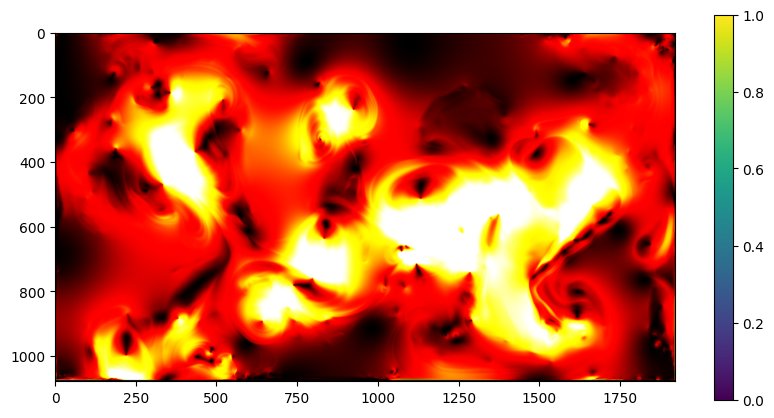

In [18]:
# plot color_rgb
color = CANVAS.numpy
plt.figure(figsize=(10,5))
plt.imshow(color)
plt.colorbar()
plt.show()


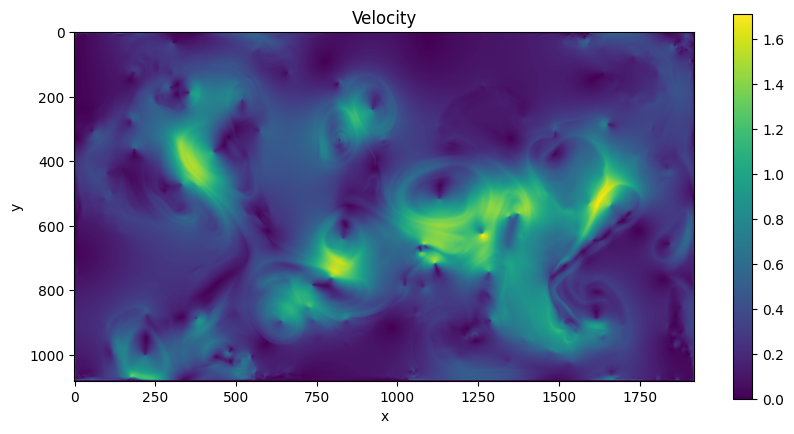

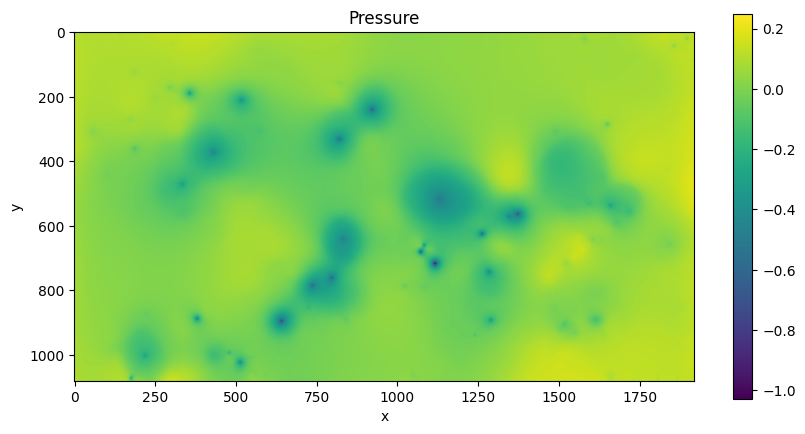

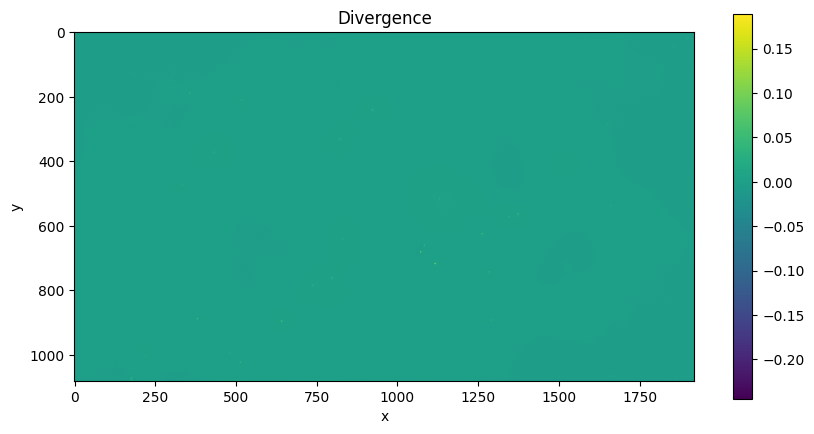

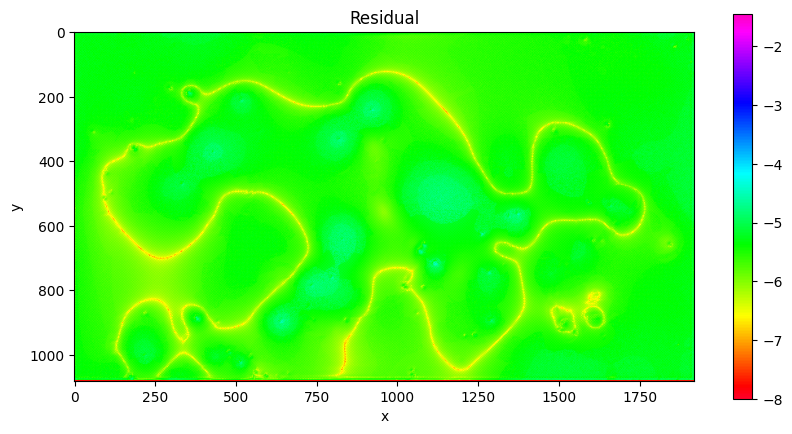

In [19]:
# plot the final velocity with colorbar
plt.figure(figsize=(10,5))
plt.imshow(np.sqrt(VX.numpy**2.0 + VY.numpy**2.0))
plt.colorbar()
plt.title('Velocity')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the final pressure with colorbar
plt.figure(figsize=(10,5))
plt.imshow(PRESSURE.numpy)
plt.colorbar()
plt.title('Pressure')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the final divergence with colorbar
plt.figure(figsize=(10,5))
plt.imshow(DIV.numpy)
plt.colorbar()
plt.title('Divergence')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the abs residual with colorbar in log scale
plt.figure(figsize=(10,5))
plt.imshow(np.log10(np.abs(RES.numpy)+1e-8), cmap='gist_rainbow')
plt.colorbar()
plt.title('Residual')
plt.xlabel('x')
plt.ylabel('y')
plt.show()